In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
warnings.filterwarnings('ignore')
# Any results you write to the current directory are saved as output.

In [2]:
from keras_preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D,Dense,Flatten, BatchNormalization,Dropout,MaxPool2D
from keras.activations import elu,relu,sigmoid
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
from keras.optimizers import Adam
from PIL import Image

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score,KFold

Using TensorFlow backend.


In [3]:
train_path = ('../input/walk-or-run/walk_or_run_train/train')
test_path = ('../input/walk-or-run/walk_or_run_test/test')
data_category=['walk', 'run']

In [4]:
train_dframe =pd.DataFrame(columns=['file_path','file_name','label'])
test_dframe =pd.DataFrame(columns=['file_path','file_name','label'])

In [5]:
iter_count = 0

for category in data_category:
    for file in (os.listdir(os.path.join(train_path,category))):
        train_dframe.loc[iter_count] = [os.path.join(train_path,category,file)]+[file]+[category]
        iter_count+=1
iter_count = 0

for category in data_category:
    for file  in (os.listdir(os.path.join(test_path,category))):
        #test_dframe.loc[iter_count] = [os.path.join(test_path,file)]+[category]
        test_dframe.loc[iter_count] = [os.path.join(test_path,file)]+[file]+[category]
        iter_count+=1

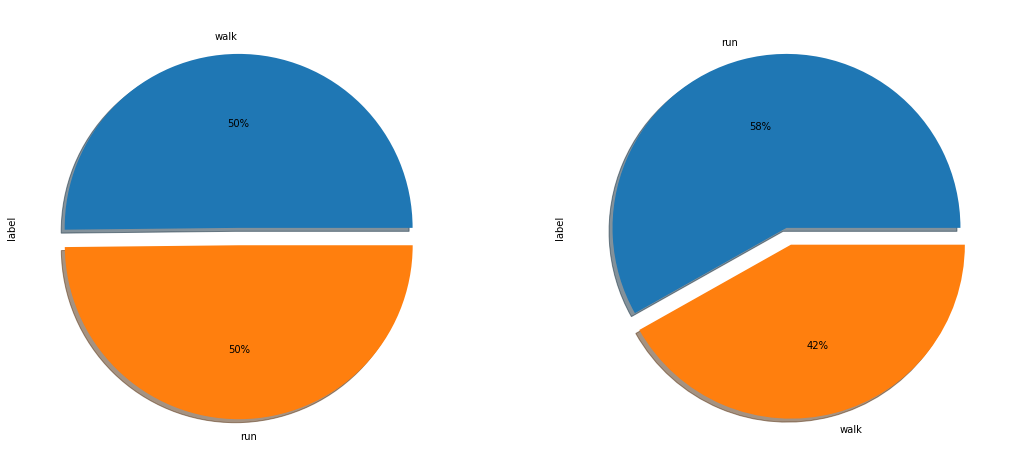

In [6]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
train_dframe['label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.f%%', ax=ax[0], shadow=True)
test_dframe['label'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.f%%', ax=ax[1], shadow=True)

In [7]:
print('train-------\n',train_dframe['label'].value_counts())
print('test--------\n',test_dframe['label'].value_counts())

train-------
 walk    301
run     299
Name: label, dtype: int64
test--------
 run     82
walk    59
Name: label, dtype: int64


In [8]:
import seaborn as sns

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold,train_test_split

In [10]:
SSS=StratifiedShuffleSplit(n_splits=2,test_size=0.2,random_state=2019)
SFK=StratifiedKFold(n_splits=2,random_state=2019,shuffle=True)
TTS_train,TTS_test=train_test_split(train_dframe,test_size=0.2,random_state=2019,shuffle=True)

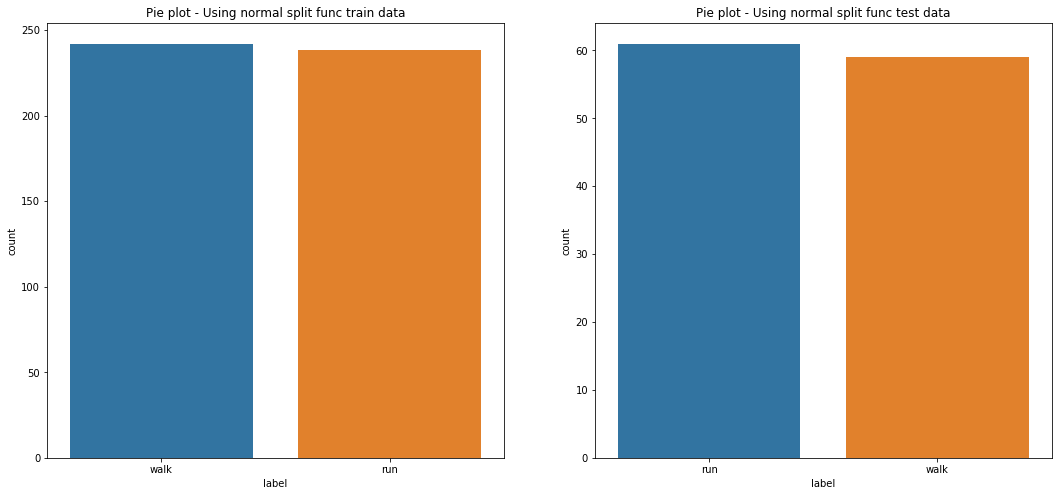

In [11]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].set_title('Pie plot - Using normal split func train data')
sns.countplot('label', data=TTS_train, ax=ax[0])
ax[1].set_title('Pie plot - Using normal split func test data')
sns.countplot('label', data=TTS_test, ax=ax[1])

run => 1 , walk => 0

In [12]:
train_dframe['label'] =train_dframe['label'].apply(lambda x:'1' if x== 'run'else '0')
test_dframe['label'] = test_dframe['label'].apply(lambda x:'1' if x== 'run'else '0')

In [13]:
SFK.get_n_splits(train_dframe['file_path'],train_dframe['label'])
SFK_PATH = '../input/SFK'
SFK_TRAIN = os.path.join(SFK_PATH,'train')
SFK_VALID = os.path.join(SFK_PATH,'valid')
if not 'SFK' in os.listdir('../input'):
    os.mkdir(SFK_PATH)
if not 'train' in os.listdir(SFK_PATH):
    os.mkdir(SFK_TRAIN)
    os.mkdir(os.path.join(SFK_TRAIN,'walk'))
    os.mkdir(os.path.join(SFK_TRAIN,'run'))
if not 'valid' in os.listdir(SFK_PATH):
    os.mkdir(SFK_VALID)
    os.mkdir(os.path.join(SFK_VALID,'walk'))
    os.mkdir(os.path.join(SFK_VALID,'run'))
train_index, _ = SSS.split(train_dframe['file_path'],train_dframe['label'])
SSS_train_index = train_index[0]
SSS_vaild_index = train_index[1]

In [14]:
def get_CNN_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(224, 224, 4),activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(2,2))    
    model.add(Conv2D(32, (3, 3), padding='same',activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(3,3))
    model.add(Conv2D(32, (3, 3), padding='same',activation='elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='valid',activation='elu'))
    model.add(MaxPool2D(2,2))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same',activation='elu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(16,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00003), metrics=['accuracy'])
    print(model.summary())
    return model

**0 is walk 1 is run**

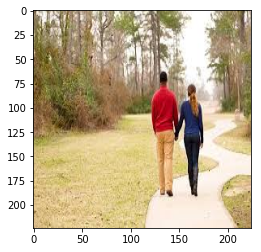

In [15]:
tmp_img = plt.imread(train_dframe['file_path'][0])
plt.imshow(tmp_img)

In [16]:
for index in SSS_train_index:
    
    if(train_dframe['label'][int(index)]=='0'):
        cate ='walk'
    else:
        cate='run'
    tmp_img = Image.open(train_dframe['file_path'][int(index)])
    tmp_img.save(os.path.join(SFK_TRAIN,cate,train_dframe['file_name'][int(index)]))
    
    
for index in SSS_vaild_index:
    if(train_dframe['label'][int(index)]=='0'):
        cate ='walk'
    else:
        cate='run'
    tmp_img = Image.open(train_dframe['file_path'][int(index)])
    tmp_img.save(os.path.join(SFK_VALID,cate,train_dframe['file_name'][int(index)]))

In [17]:
TTS_train['label'] = TTS_train['label'].apply(lambda x:'1' if x== 'run'else '0')
Y_TTS_train_lable = list(TTS_train['label'])
TTS_test['label'] = TTS_test['label'].apply(lambda x:'1' if x== 'run'else '0')
Y_TTS_test_lable = list(TTS_test['label'])

In [18]:
train_gen = ImageDataGenerator(
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
)
vaild_gen = ImageDataGenerator()
test_gen = ImageDataGenerator()
batch_size=32

In [19]:
train_generator = train_gen.flow_from_directory(directory=SFK_TRAIN,
                                                target_size=(224, 224),
                                                batch_size=batch_size,class_mode='binary',color_mode="rgba")
vaild_generator = vaild_gen.flow_from_directory(directory=SFK_VALID,
                                                target_size=(224, 224),
                                                batch_size=batch_size,class_mode='binary',color_mode="rgba")
test_generator = test_gen.flow_from_directory(directory=test_path,
                                              target_size=(224, 224),
                                              batch_size=batch_size,class_mode='binary',color_mode="rgba")

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


In [20]:
SCM = get_CNN_model()
callbacks = [ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      1184      
_________________________________________________________________
batch_normalization_1 (Batch (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 32)        9248      
__________

In [21]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [22]:
SCM.fit_generator(
    train_generator,
    steps_per_epoch = 480,
    epochs=30,
    validation_data = vaild_generator,
    validation_steps = 120,
    callbacks = callbacks
)

Epoch 1/30
480/480 [==============================] - 256s 534ms/step - loss: 0.6809 - acc: 0.6003 - val_loss: 0.6336 - val_acc: 0.6500
Epoch 2/30
480/480 [==============================] - 246s 512ms/step - loss: 0.6052 - acc: 0.6615 - val_loss: 0.6248 - val_acc: 0.6750
Epoch 3/30
480/480 [==============================] - 241s 502ms/step - loss: 0.5635 - acc: 0.6917 - val_loss: 0.6434 - val_acc: 0.6833
Epoch 4/30
480/480 [==============================] - 232s 483ms/step - loss: 0.5304 - acc: 0.7177 - val_loss: 0.6291 - val_acc: 0.7000
Epoch 5/30
480/480 [==============================] - 235s 490ms/step - loss: 0.4927 - acc: 0.7512 - val_loss: 0.6567 - val_acc: 0.7417
Epoch 6/30
480/480 [==============================] - 238s 495ms/step - loss: 0.4816 - acc: 0.7572 - val_loss: 0.6733 - val_acc: 0.7500
Epoch 7/30
480/480 [==============================] - 240s 501ms/step - loss: 0.4766 - acc: 0.7593 - val_loss: 0.6723 - val_acc: 0.7333
Epoch 8/30
480/480 [============================

In [23]:
SCM.evaluate_generator(test_generator,60)

[0.6908408837749603, 0.7588652492133157]